### Import Libraries

In [1]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models

### Load Audio File Dataset

In [2]:
DATASET_PATH = 'dataset'
data_dir = pathlib.Path(DATASET_PATH)

### Divide the Dataset into Train and Validation

In [3]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.3,
    seed=0,
    output_sequence_length=16000,
    subset='both',
)

Found 6505 files belonging to 4 classes.
Using 4554 files for training.
Using 1951 files for validation.


In [4]:
label_names = np.array(train_ds.class_names)
print(label_names)
num_labels = len(label_names)

['follow' 'learn' 'tree' 'visual']


### Squeezing

In [5]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    #removes the last dimension (axis=-1) of the audio tensor
    return audio, labels

In [6]:
#applies the squeeze function to all elements
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
#tf.data.AUTOTUNE helps optimize the preprocessing 
#performance by automatically tuning the number of parallel calls.


### Create Testing Data

In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

#.shard() is used to split the dataset into multiple smaller subsets
#- num_shards=2: This means the original dataset (val_ds) is being split into 2 equal parts.
#- index=0: This selects the first shard (i.e., the first half of the dataset) and assigns it to test_ds.
#- index=1: This selects the second shard (i.e., the second half of the dataset) and assigns it back to val_ds.


### Generate Spectrogram Data

In [8]:
def get_spectrogram(waveform):
    #Short-Time Fourier Transform
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    #- frame_length=255: Defines the size of each windowed segment.
    #- frame_step=128: Controls the overlap between consecutive windows
    
    #The STFT output contains complex numbers.
    #tf.abs() extracts only the magnitude
    spectrogram = tf.abs(spectrogram)
    #tf.newaxis adds a new dimension, 
    #making the spectrogram suitable for input into a CNN mode
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [9]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )


### Converting the Audio Array into A Spectrogram

In [10]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [11]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### Build the Model

In [12]:
# Ambil satu batch contoh spectrogram dari dataset training
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

In [13]:
input_shape = example_spectrograms.shape[1:]
#skips first dimension

In [14]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(
    map_func=lambda spec, label: spec  # ambil hanya spectrogram-nya
))

In [15]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,375 (1.20 MB)

 Trainable params: 314,372 (1.20 MB)

 Non-trainable params: 3 (16.00 B)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the Model

In [18]:
EPOCHS = 10

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds, 
    epochs=EPOCHS, 
    callbacks=tf.keras.callbacks.EarlyStopping(
        verbose=1,
        patience=2
    ),
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.5300 - loss: 1.0733 - val_accuracy: 0.8042 - val_loss: 0.6227
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7932 - loss: 0.5833 - val_accuracy: 0.8375 - val_loss: 0.4855
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8450 - loss: 0.4546 - val_accuracy: 0.8656 - val_loss: 0.4178
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8792 - loss: 0.3522 - val_accuracy: 0.8854 - val_loss: 0.3646
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8887 - loss: 0.3191 - val_accuracy: 0.8938 - val_loss: 0.3255
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9072 - loss: 0.2873 - val_accuracy: 0.9052 - val_loss: 0.2918
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9217 - loss: 0.2318 - val_accuracy: 0.9073 - val_loss: 0.2887
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9262 - loss: 0.2249 - val_accuracy: 0.9104 - v

### Evaluate the Model

Text(0, 0.5, 'Accuracy [%]')

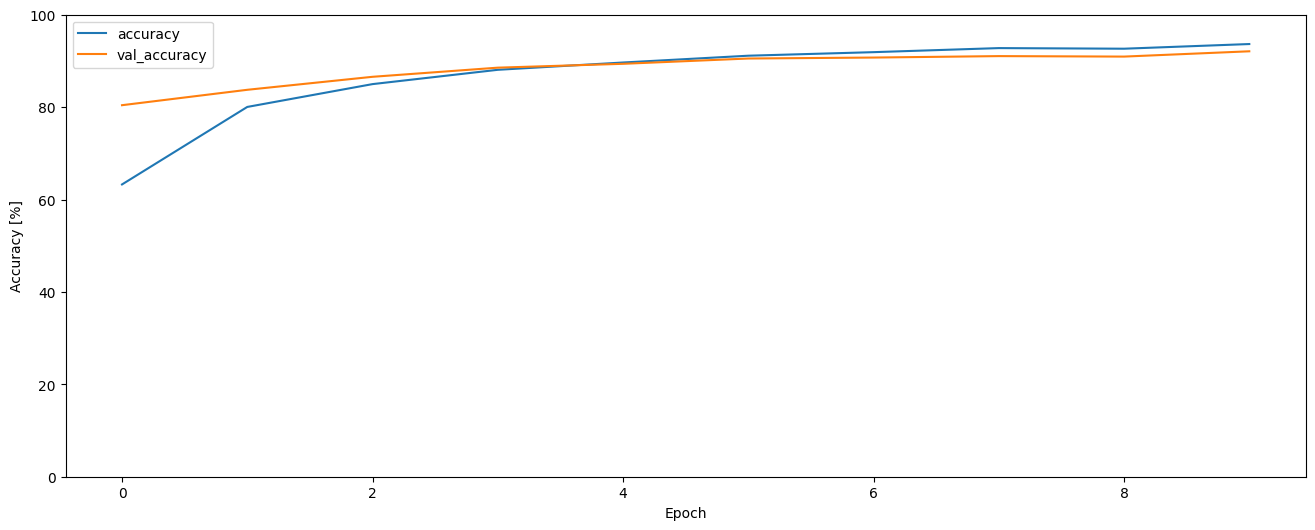

In [19]:
# Plotting accuracy CNN setiap epoch
metrics = history.history
plt.figure(figsize=(16,6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [20]:
test_results = model.evaluate(test_spectrogram_ds, return_dict=True)
#return_dict agar mudah dapat accuracy
accuracy = test_results['accuracy']
print("Accuracy on test set = {:.2f}%".format(accuracy * 100))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9332 - loss: 0.1906
Accuracy on test set = 93.14%


### Predict

In [21]:
ctr = 0
#i is batch, j is per item
for i, (spectrogram, label) in enumerate(test_spectrogram_ds):
    pred = model.predict(spectrogram)
    pred_label_idx = tf.argmax(pred, axis=1).numpy()  # Convert to numpy array
    orig_label = label_names[label.numpy()]
    pred_label = [label_names[idx] for idx in pred_label_idx]  # Use list comprehension
    for j, label in enumerate(orig_label):
        ctr += 1
        print("Data %d: Original Label -> %s, Prediction -> %s" % (ctr, label, pred_label[j]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Data 1: Original Label -> tree, Prediction -> tree
Data 2: Original Label -> learn, Prediction -> learn
Data 3: Original Label -> tree, Prediction -> tree
Data 4: Original Label -> tree, Prediction -> tree
Data 5: Original Label -> tree, Prediction -> tree
Data 6: Original Label -> visual, Prediction -> visual
Data 7: Original Label -> tree, Prediction -> tree
Data 8: Original Label -> visual, Prediction -> visual
Data 9: Original Label -> learn, Prediction -> learn
Data 10: Original Label -> visual, Prediction -> visual
Data 11: Original Label -> visual, Prediction -> visual
Data 12: Original Label -> follow, Prediction -> follow
Data 13: Original Label -> learn, Prediction -> learn
Data 14: Original Label -> tree, Prediction -> tree
Data 15: Original Label -> tree, Prediction -> tree
Data 16: Original Label -> visual, Prediction -> visual
Data 17: Original Label -> tree, Prediction -> tree
Data 18: Original Label -> tree, Prediction -> tree
Data 